In [1]:
import time
from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score, f1_score
from dhg import Hypergraph
from dhg.data import *
from dhg.models import *
from dhg.random import set_seed
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator

data = CoauthorshipCora()
G = Hypergraph(data["num_vertices"], data["edge_list"])
print(G)
# train_mask = data["train_mask"]
# val_mask = data["val_mask"]
# test_mask = data["test_mask"]

# # 设置随机种子，以确保结果可复现
random_seed = 42

node_idx = [i for i in range(data['num_vertices'])]

labels = data["labels"]
y = labels.numpy()
# 将idx_test划分为训练（60%）、验证（20%）和测试（20%）集
idx_train, idx_temp, train_y, tem_y = train_test_split(node_idx, y, test_size=0.5, random_state=random_seed, stratify=y)
idx_val, idx_test, val_y, test_y = train_test_split(idx_temp, tem_y, test_size=0.5, random_state=random_seed, stratify=tem_y)
# 将idx_test划分为训练（50%）、验证（25%）和测试（25%）集
# idx_train, idx_temp = train_test_split(node_idx, test_size=0.5, random_state=random_seed)
# idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, random_state=random_seed)

# 确保划分后的集合没有重叠
assert len(set(idx_train) & set(idx_val)) == 0
assert len(set(idx_train) & set(idx_test)) == 0
assert len(set(idx_val) & set(idx_test)) == 0

train_mask = torch.zeros(data['num_vertices'], dtype=torch.bool)
val_mask = torch.zeros(data['num_vertices'], dtype=torch.bool)
test_mask = torch.zeros(data['num_vertices'], dtype=torch.bool)
train_mask[idx_train] = True
val_mask[idx_val] = True
test_mask[idx_test] = True

# idx_train = np.where(train_mask)[0]
# idx_val = np.where(val_mask)[0]
# idx_test = np.where(test_mask)[0]

# v_deg= G.D_v
# X = v_deg.to_dense()/torch.max(v_deg.to_dense())
X = data["features"]
lbls = data["labels"]
print('X dim:', X.shape)
print('labels:', len(torch.unique(lbls)))


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

set_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])


num_epochs = 200


X, lbls = X.to(device), lbls.to(device)
G = G.to(device)

net = HGNN(X.shape[1], 64, data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)
# scheduler = StepLR(optimizer, step_size=int(num_epochs/5), gamma=0.1)
net = net.to(device)

print(f'net:{net}')

/users/Min/miniconda/envs/hy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Hypergraph(num_v=2708, num_e=970)
X dim: torch.Size([2708, 1433])
labels: 7
net:HGNN(
  (layers): ModuleList(
    (0): HGNNConv(
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (theta): Linear(in_features=1433, out_features=64, bias=True)
    )
    (1): HGNNConv(
      (bn): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (theta): Linear(in_features=64, out_features=7, bias=True)
    )
  )
)


In [2]:
net.eval()
with torch.no_grad():
    outs = net(X, G)
    outs, lbl = outs[idx_test], lbls[idx_test]
    
    
    # Calculate accuracy
    _, predicted = torch.max(outs, 1)

    predicted_array = predicted.cpu().numpy()
    # 保存到文件
    np.savetxt('res/bkhgnn_predicted_coauthorcora_hid64_0104.txt', predicted_array, fmt='%d')

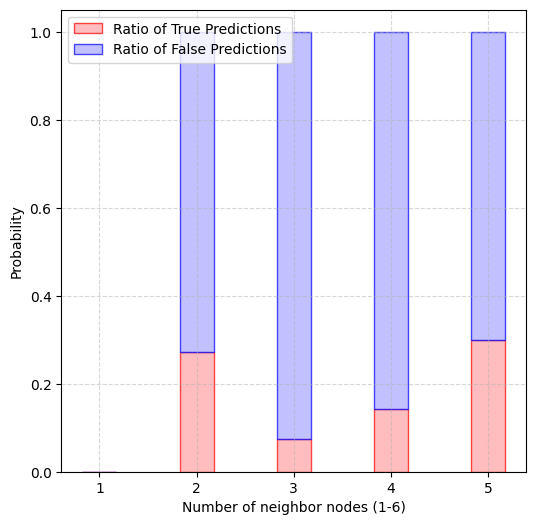

In [4]:

import numpy as np
import matplotlib.pyplot as plt

import numpy as np


A = G.H @ G.H.T
# print(A)

# 将稀疏张量转换为标准的邻接矩阵表示
adj_matrix = torch.sparse_coo_tensor(A.indices(), A.values(), A.size())

# 计算每个节点的度
degree_list = adj_matrix.to_dense().sum(dim=1)
degree_list = degree_list.cpu().numpy().tolist()


# 从文件中读取预测结果
predicted_array = np.loadtxt('res/bkhgnn_predicted_coauthorcora_hid64_0104.txt', dtype=int)
# 将numpy数组转换为列表
predicted_labels = predicted_array.tolist()
true_labels = labels[test_mask].cpu().numpy().tolist()


predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
# 计算每个节点的ACC
trues = (predicted_labels == true_labels).astype(int)
errors = [1 if value == 0 else 0 for value in trues]

degree_counts = {}
filtered_data = [(degree, value1, value2) for degree, value1, value2 in zip(degree_list, trues, errors) if 0 <= degree <= 5]

# Populate the dictionary
for degree, value1, value2 in filtered_data:
    if degree not in degree_counts:
        degree_counts[degree] = {'ones': 0, 'zeros': 0, 'total': 0}
    degree_counts[degree]['ones'] += value1
    degree_counts[degree]['zeros'] += value2
    degree_counts[degree]['total'] += 1

# Calculate the probabilities
degree_probabilities_list1 = [degree_counts.get(degree, {'ones': 0})['ones'] / degree_counts.get(degree, {'total': 1})['total'] for degree in range(1,6)]
degree_probabilities_list2 = [degree_counts.get(degree, {'zeros': 0})['zeros'] / degree_counts.get(degree, {'total': 1})['total'] for degree in range(1,6)]

# Plot the results
width = 0.35
fig, ax = plt.subplots(figsize=(6, 6))
ax.bar(np.arange(1,6), degree_probabilities_list1, width, label='Ratio of True Predictions', color='#FFA2A5', edgecolor='#FF0000',alpha=0.7)
ax.bar(np.arange(1,6), degree_probabilities_list2, width, label='Ratio of False Predictions', color='#A7A7FF', edgecolor='#0000FF',alpha=0.7, bottom=degree_probabilities_list1)
ax.set_xlabel('Number of neighbor nodes (1-6)')
ax.set_ylabel('Probability')
ax.grid(True, linestyle='--', alpha=0.5)
# ax.set_title('Ratio distribution of True and False predictions')
ax.legend(fontsize=10)
plt.savefig('figs/hgnn_true_predic_coauthorcora_hid64_0104.pdf')